In [1]:
import os
import gc
import numpy as np
import pandas as pd
import itertools
from tqdm.autonotebook import tqdm

import torch
from torch import nn
import torch.nn.functional as F

/tmp/ipykernel_3464/1217635975.py:6: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
#!pip install timm transformers albumentations opencv-python

In [3]:
import cv2
import albumentations as A
import timm
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer

* instruction: upload flicker.zip & fgsm_attack.zip to ./data folder

In [4]:
#!mkdir ./data

In [5]:
#!unzip data/flicker.zip -d ./data

In [6]:
class CFG:
    debug = False
    image_path = "./data/Images"
    captions_path = "./data/"
    batch_size = 64
    num_workers = 4
    head_lr = 1e-3
    image_encoder_lr = 1e-4
    text_encoder_lr = 1e-5
    weight_decay = 1e-3
    patience = 1
    factor = 0.8
    epochs = 200
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model_name = 'resnet50'
    image_embedding = 2048
    text_encoder_model = "distilbert-base-uncased"
    text_embedding = 768
    text_tokenizer = "distilbert-base-uncased"
    max_length = 200

    pretrained = True # for both image encoder and text encoder
    trainable = True # for both image encoder and text encoder
    temperature = 1.0

    # image size
    size = 224

    # for projection head; used for both image and text encoders
    num_projection_layers = 1
    projection_dim = 256 
    dropout = 0.1

In [7]:
class AvgMeter:
    def __init__(self, name="Metric"):
        self.name = name
        self.reset()

    def reset(self):
        self.avg, self.sum, self.count = [0] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += val * count
        self.avg = self.sum / self.count

    def __repr__(self):
        text = f"{self.name}: {self.avg:.4f}"
        return text

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]

In [207]:
class CLIPDataset(torch.utils.data.Dataset):
    def __init__(self, image_filenames, captions, tokenizer, transforms, image_path=None):
        """
        image_filenames and cpations must have the same length; so, if there are
        multiple captions for each image, the image_filenames must have repetitive
        file names 
        """

        self.image_filenames = image_filenames
        self.captions = list(captions)
        self.encoded_captions = tokenizer(
            list(captions), padding=True, truncation=True, max_length=CFG.max_length
        )
        self.transforms = transforms
        # Hnin: Updated to have different image_path for inference
        if image_path is None:
            self.image_path = CFG.image_path
        else: 
            self.image_path = image_path

    def __getitem__(self, idx):
        item = {
            key: torch.tensor(values[idx])
            for key, values in self.encoded_captions.items()
        }
        if self.image_path is None:
            image = cv2.imread(f"{self.image_path}/{self.image_filenames[idx]}")
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = self.transforms(image=image)['image']
            item['image'] = torch.tensor(image).permute(2, 0, 1).float()
        
        item['caption'] = self.captions[idx]
        
        return item


    def __len__(self):
        return len(self.captions)

    def __len__(self):
        return len(self.captions)


def get_transforms(mode="train"):
    if mode == "train":
        return A.Compose(
            [
                A.Resize(CFG.size, CFG.size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )
    else:
        return A.Compose(
            [
                A.Resize(CFG.size, CFG.size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )

In [9]:
class ImageEncoder(nn.Module):
    """
    Encode images to a fixed size vector
    """

    def __init__(
        self, model_name=CFG.model_name, pretrained=CFG.pretrained, trainable=CFG.trainable
    ):
        super().__init__()
        self.model = timm.create_model(
            model_name, pretrained, num_classes=0, global_pool="avg"
        )
        for p in self.model.parameters():
            p.requires_grad = trainable

    def forward(self, x):
        return self.model(x)

In [10]:
class TextEncoder(nn.Module):
    def __init__(self, model_name=CFG.text_encoder_model, pretrained=CFG.pretrained, trainable=CFG.trainable):
        super().__init__()
        if pretrained:
            self.model = DistilBertModel.from_pretrained(model_name)
        else:
            self.model = DistilBertModel(config=DistilBertConfig())
            
        for p in self.model.parameters():
            p.requires_grad = trainable

        # we are using the CLS token hidden representation as the sentence's embedding
        self.target_token_idx = 0

    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = output.last_hidden_state
        return last_hidden_state[:, self.target_token_idx, :]

In [11]:
class ProjectionHead(nn.Module):
    def __init__(
        self,
        embedding_dim,
        projection_dim=CFG.projection_dim,
        dropout=CFG.dropout
    ):
        super().__init__()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)
    
    def forward(self, x):
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected
        x = self.layer_norm(x)
        return x

In [12]:
class CLIPModel(nn.Module):
    def __init__(
        self,
        temperature=CFG.temperature,
        image_embedding=CFG.image_embedding,
        text_embedding=CFG.text_embedding,
    ):
        super().__init__()
        self.image_encoder = ImageEncoder()
        self.text_encoder = TextEncoder()
        self.image_projection = ProjectionHead(embedding_dim=image_embedding)
        self.text_projection = ProjectionHead(embedding_dim=text_embedding)
        self.temperature = temperature

    def forward(self, batch):
        # Getting Image and Text Features
        image_features = self.image_encoder(batch["image"])
        text_features = self.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        # Getting Image and Text Embeddings (with same dimension)
        image_embeddings = self.image_projection(image_features)
        text_embeddings = self.text_projection(text_features)

        # Calculating the Loss
        logits = (text_embeddings @ image_embeddings.T) / self.temperature
        images_similarity = image_embeddings @ image_embeddings.T
        texts_similarity = text_embeddings @ text_embeddings.T
        targets = F.softmax(
            (images_similarity + texts_similarity) / 2 * self.temperature, dim=-1
        )
        texts_loss = cross_entropy(logits, targets, reduction='none')
        images_loss = cross_entropy(logits.T, targets.T, reduction='none')
        loss =  (images_loss + texts_loss) / 2.0 # shape: (batch_size)
        return loss.mean()


def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()

In [39]:
def make_train_valid_dfs():
    dataframe = pd.read_csv(f"{CFG.captions_path}/captions.txt")
    dataframe.insert(0, 'id', range(0, len(dataframe)))
    max_id = dataframe["id"].max() + 1 if not CFG.debug else 100
    image_ids = np.arange(0, max_id)
    np.random.seed(42)
    valid_ids = np.random.choice(
        image_ids, size=int(0.2 * len(image_ids)), replace=False
    )
    train_ids = [id_ for id_ in image_ids if id_ not in valid_ids]
    train_dataframe = dataframe[dataframe["id"].isin(train_ids)].reset_index(drop=True)
    valid_dataframe = dataframe[dataframe["id"].isin(valid_ids)].reset_index(drop=True)
    return train_dataframe, valid_dataframe


def build_loaders(dataframe, tokenizer, mode, image_path=None):
    transforms = get_transforms(mode=mode)
    dataset = CLIPDataset(
        dataframe["image"].values,
        dataframe["caption"].values,
        tokenizer=tokenizer,
        transforms=transforms,
        image_path=image_path,
    )
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=CFG.batch_size,
        num_workers=CFG.num_workers,
        shuffle=True if mode == "train" else False,
    )
    return dataloader

In [14]:
def train_epoch(model, train_loader, optimizer, lr_scheduler, step):
    loss_meter = AvgMeter()
    tqdm_object = tqdm(train_loader, total=len(train_loader))
    for batch in tqdm_object:
        batch = {k: v.to(CFG.device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if step == "batch":
            lr_scheduler.step()

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(train_loss=loss_meter.avg, lr=get_lr(optimizer))
    return loss_meter


def valid_epoch(model, valid_loader):
    loss_meter = AvgMeter()

    tqdm_object = tqdm(valid_loader, total=len(valid_loader))
    for batch in tqdm_object:
        batch = {k: v.to(CFG.device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(valid_loss=loss_meter.avg)
    return loss_meter

In [15]:
def write_logs(file_name, message):
    f = open(file_name, "a")
    f.write(message + '\n')
    f.close()

In [16]:
def main():
    train_df, valid_df = make_train_valid_dfs()
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    train_loader = build_loaders(train_df, tokenizer, mode="train")
    valid_loader = build_loaders(valid_df, tokenizer, mode="valid")


    model = CLIPModel().to(CFG.device)
    params = [
        {"params": model.image_encoder.parameters(), "lr": CFG.image_encoder_lr},
        {"params": model.text_encoder.parameters(), "lr": CFG.text_encoder_lr},
        {"params": itertools.chain(
            model.image_projection.parameters(), model.text_projection.parameters()
        ), "lr": CFG.head_lr, "weight_decay": CFG.weight_decay}
    ]
    optimizer = torch.optim.AdamW(params, weight_decay=0.)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=CFG.patience, factor=CFG.factor
    )
    step = "epoch"

    log_file_name = 'trainvalLoss.txt'
    
    best_loss = float('inf')
    for epoch in range(CFG.epochs):
        print(f"Epoch: {epoch + 1}")
        model.train()
        train_loss = train_epoch(model, train_loader, optimizer, lr_scheduler, step)
        model.eval()
        with torch.no_grad():
            valid_loss = valid_epoch(model, valid_loader)
        
        if valid_loss.avg < best_loss:
            best_loss = valid_loss.avg
            torch.save(model.state_dict(), str(epoch)+"_"+str(best_loss)+"_model.pt")
            print("Saved Best Model!")
        
        lr_scheduler.step(valid_loss.avg)
    
         ## log loss
        write_logs(log_file_name, f"{epoch}, {train_loss.avg:.5f}, {valid_loss.avg:.5f},  {best_loss:.5f}")

In [ ]:
main()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: 1


  0%|          | 0/506 [00:00<?, ?it/s]

### Train/Val Loss Graph

In [ ]:
import pandas
data=pandas.read_csv('trainvalLoss.txt', sep=',', header=None, names=["Epoch", "Train Loss", "Val Loss", "Best Loss"])

fig = plt.figure(figsize=(15, 8))
plt.plot(range(len(data["Epoch"])), data["Train Loss"], "-r", label="train loss")
plt.plot(range(len(data["Epoch"])), data["Val Loss"], "-g", label="val loss")

ax = plt.gca()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(range(len(data["Epoch"])))
plt.legend(loc="upper right")
plt.show()

### Get Matches

In [177]:
def get_image_embeddings(valid_df, model_path):
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    valid_loader = build_loaders(valid_df, tokenizer, mode="valid")
    
    model = CLIPModel().to(CFG.device)
    model.load_state_dict(torch.load(model_path, map_location=CFG.device))
    model.eval()
    
    valid_image_embeddings = []
    with torch.no_grad():
        for batch in tqdm(valid_loader):
            image_features = model.image_encoder(batch["image"].to(CFG.device))
            image_embeddings = model.image_projection(image_features)
            valid_image_embeddings.append(image_embeddings)
    return model, torch.cat(valid_image_embeddings)

In [178]:
_, valid_df = make_train_valid_dfs()
model, image_embeddings = get_image_embeddings(valid_df, "best.pt")

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/127 [00:00<?, ?it/s]

In [179]:
import matplotlib.pyplot as plt 

def find_matches(model, image_embeddings, query, image_filenames, n=9):
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    encoded_query = tokenizer([query])
    batch = {
        key: torch.tensor(values).to(CFG.device)
        for key, values in encoded_query.items()
    }
    with torch.no_grad():
        text_features = model.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        text_embeddings = model.text_projection(text_features)
    
    image_embeddings_n = F.normalize(image_embeddings, p=2, dim=-1)
    text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)
    dot_similarity = text_embeddings_n @ image_embeddings_n.T
    
    values, indices = torch.topk(dot_similarity.squeeze(0), n * 5)
    matches = [image_filenames[idx] for idx in indices[::5]]
    
    _, axes = plt.subplots(3, 3, figsize=(10, 10))
    for match, ax in zip(matches, axes.flatten()):
        image = cv2.imread(f"{CFG.image_path}/{match}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(image)
        ax.axis("off")
    
    plt.show()

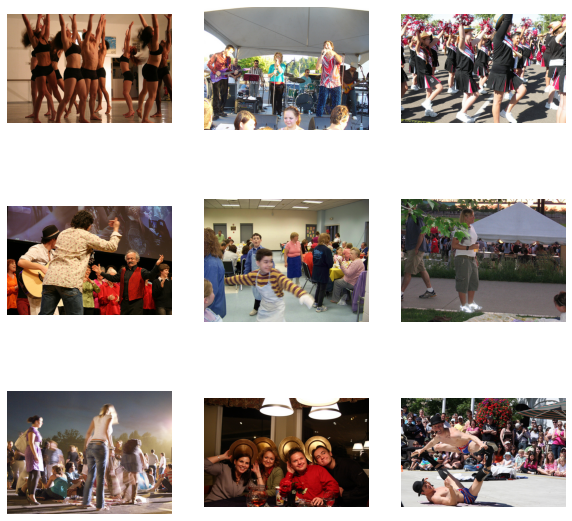

In [180]:
find_matches(model, 
             image_embeddings,
             query="a group of people dancing in a party",
             image_filenames=valid_df['image'].values,
             n=9)

## Code modification (input query as image, output Top-k 'text' matches)

In [238]:
def make_adverserial_inference_df(inference_path, fgsm = False):
    '''
    Create dataframe for our inference files
    inference_path: path to our inference folder 
    
    retunrs df with image pointing to image filename and caption to the correct label 
    '''
    file_path_names = os.listdir(inference_path)
    d = {} 
    d['image'] = file_path_names
    captions = []
    for file_path in file_path_names:
        if fgsm:
            name = os.path.splitext(file_path)[0] # remove .JPEG from the end 
            name = ' '.join(name.split('_'))  # "01669191_box_turtle"  to "box turtle"
            name = "This is " + name  # "box turtle" to "This is box turtle"
        else:
            name = os.path.splitext(file_path)[0] # remove .JPEG from the end 
            name = ' '.join(name.split('_')[1:])  # "01669191_box_turtle"  to "box turtle"
            name = "This is " + name  # "box turtle" to "This is box turtle"
        captions.append(name)
    d['caption'] = captions 
    df = pd.DataFrame(data=d)
    
    return df 

In [208]:
def get_text_embeddings(valid_df, model_path, inference_path):
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    valid_loader = build_loaders(valid_df, tokenizer, mode="valid", image_path=inference_path)
    
    model = CLIPModel().to(CFG.device)
    model.load_state_dict(torch.load(model_path, map_location=CFG.device))
    model.eval()
    
    valid_text_embeddings = []
    with torch.no_grad():
        for batch in tqdm(valid_loader):
            #print(f"Atttention mask is {batch['attention_mask']}")
            text_features = model.text_encoder(
                input_ids=batch["input_ids"].to(CFG.device), attention_mask=batch["attention_mask"].to(CFG.device)
            )    
            text_embeddings = model.text_projection(text_features)
            valid_text_embeddings.append(text_embeddings)
    return model, torch.cat(valid_text_embeddings)

In [ ]:
def get_text_embeddings_inf(df, model_path):
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    model = CLIPModel().to(CFG.device)
    model.load_state_dict(torch.load(model_path, map_location=CFG.device))
    model.eval()
    
    captions = df['caption'].values 
    
    # Encode all the captions 
    encoded_captions = tokenizer(list(captions), padding=True, truncation=True, max_length=CFG.max_length)

In [47]:
inf_df = make_adverserial_inference_df("data/pgdAttack")

In [48]:
inf_df

,image,caption
0,n02979186_cassette_player.JPEG,This is cassette player
1,n02113799_standard_poodle.JPEG,This is standard poodle
2,n02437312_Arabian_camel.JPEG,This is Arabian camel
3,n04154565_screwdriver.JPEG,This is screwdriver
4,n12998815_agaric.JPEG,This is agaric
...,...,...
995,n01582220_magpie.JPEG,This is magpie
996,n03874599_padlock.JPEG,This is padlock
997,n03240683_drilling_platform.JPEG,This is drilling platform
998,n01795545_black_grouse.JPEG,This is black grouse


In [49]:
model, text_embeddings = get_text_embeddings(inf_df, "best.pt", "data/pgdAttack")

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 22.28it/s]


In [182]:
#_, valid_df = make_train_valid_dfs()
#model, text_embeddings = get_text_embeddings(valid_df, "best.pt")

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/127 [00:00<?, ?it/s]

In [183]:
import matplotlib.pyplot as plt 


## query: image -> output: top k likely captions
def find_matches_new(model, text_embeddings, image_query, image_captions, n=9):
    
    with torch.no_grad():
        image_features = model.image_encoder(image_query)
        image_embeddings = model.image_projection(image_features)
    
    image_embeddings_n = F.normalize(image_embeddings, p=2, dim=-1)
    text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)
    dot_similarity = text_embeddings_n @ image_embeddings_n.T
    values, indices = torch.topk(dot_similarity.squeeze(1), n * 5)
    matches = [image_captions[idx.detach().cpu().numpy()] for idx in indices[::5]]

    for match in matches:
        print(match)
        print()

In [174]:
def find_matches_caption(model, text_embeddings, image_query, image_captions, n=5):
    
    """
        Return top n matches 
    """
    with torch.no_grad():
        image_features = model.image_encoder(image_query)
        image_embeddings= model.image_projection(image_features)
    image_embeddings_n = F.normalize(image_embeddings, p=2, dim=-1)
    text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)
    dot_similarity = text_embeddings_n @ image_embeddings_n.T
    values, indices = torch.topk(dot_similarity.squeeze(1), n * 5)
    #print(values)
    #print(indices)
    matches = [image_captions[idx.detach().cpu().numpy()] for idx in indices[:n]]
    
    return matches 

In [129]:
from PIL import Image
import torchvision
from torchvision import transforms

def preprocess_inf_img(image_path):
    image = Image.open(image_path).convert('RGB')
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

    image = preprocess(image)
    
    return image

In [130]:
pgdAttack_names = os.listdir('data/pgdAttack')

In [167]:
pgdAttack_names[125]

'n04435653_tile_roof.JPEG'

In [162]:
image = preprocess_inf_img("data/originalImagenet/"+ pgdAttack_names[125])

In [163]:
import matplotlib.pyplot as plt 

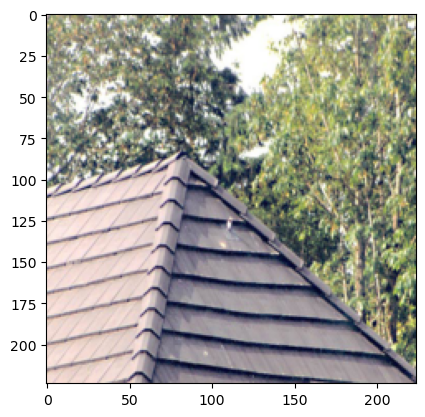

In [164]:
plt.imshow(image.permute(1, 2, 0).float())

In [165]:
result = torch.unsqueeze(image, 0)
find_matches_caption(model, 
             text_embeddings,
             image_query= result.cuda(),
             image_captions = inf_df['caption'],
             n=5)

tensor([0.9220, 0.9214, 0.9166, 0.9158, 0.9144, 0.9137, 0.9129, 0.9122, 0.9120,
        0.9117, 0.9112, 0.9110, 0.9108, 0.9103, 0.9102, 0.9101, 0.9100, 0.9094,
        0.9086, 0.9082, 0.9081, 0.9080, 0.9076, 0.9075, 0.9074],
       device='cuda:0')
tensor([ 84, 125,  47, 689, 499, 714, 829, 983, 138, 698, 616, 635, 687, 614,
        117, 417, 647, 405, 996, 922, 900, 327,  98, 210, 300],
       device='cuda:0')


['This is Leonberg',
 'This is tile roof',
 'This is window shade',
 'This is safe',
 'This is sliding door']

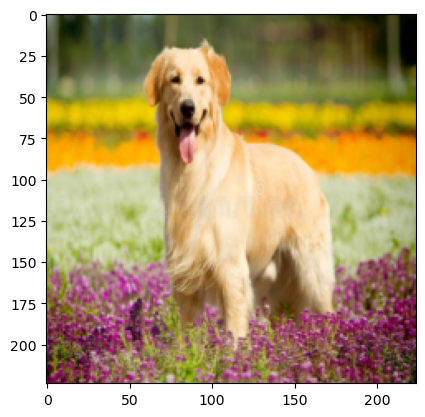

In [114]:
from PIL import Image
import torchvision
from torchvision import transforms

image = Image.open('./sample.jpg').convert('RGB')

preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

image = preprocess(image)
plt.imshow(image.permute(1, 2, 0).float())

result = torch.unsqueeze(image, 0)

In [93]:
find_matches_caption(model, 
             text_embeddings,
             image_query= result.cuda(),
             image_captions = inf_df['caption'],
             n=5)

['This is kelpie',
 'This is Kerry blue terrier',
 'This is Great Dane',
 'This is groenendael',
 'This is badger']

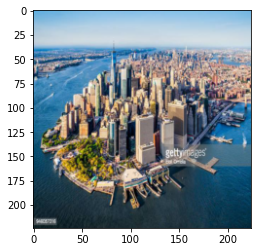

In [303]:
image = Image.open('./sample2.jpg').convert('RGB')

preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

image = preprocess(image)
plt.imshow(image.permute(1, 2, 0).float())

result = torch.unsqueeze(image, 0)

In [305]:
find_matches_new(model, 
             text_embeddings,
             image_query= result.cuda(),
             image_captions = valid_df['caption'],
             n=5)

Two people sit on a dock next to each other watching the sunset .

People stand on the balcony and deck of a boat .

A stone dock and a couple hugging at the end , water behind .

Kids playing in the water in front of a wooden bridge .

Two canoes cross the water , behind them are some houses .



## Create Adversarial ImageNet dataset subset

- download clean ImageNet subset

In [191]:
!git clone https://github.com/EliSchwartz/imagenet-sample-images.git ./data/originalImagenet

Cloning into './data/originalImagenet'...
remote: Enumerating objects: 1012, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 1012 (delta 3), reused 5 (delta 2), pack-reused 1002
Receiving objects: 100% (1012/1012), 103.84 MiB | 39.25 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [207]:
!rm -rf data/originalImagenet/*.md

In [233]:
!git clone https://gist.github.com/942d3a0ac09ec9e5eb3a.git ./data/ImageNetLabel

Cloning into './data/ImageNetLabel'...
remote: Enumerating objects: 6, done.
remote: Total 6 (delta 0), reused 0 (delta 0), pack-reused 6
Unpacking objects: 100% (6/6), done.


In [383]:
# Load names for ImageNet classes
object_categories = {}
with open('./data/ImageNetLabel/imagenet1000_clsidx_to_labels.txt', "r") as f:
    for line in f:
        key, val = line.strip().replace("{","").replace("}","").split(":")
        object_categories[key] = val

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


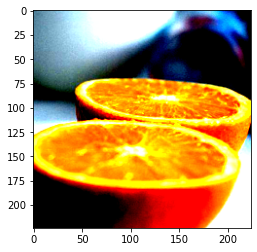

In [384]:
image = Image.open('./data/originalImagenet/n07747607_orange.JPEG').convert('RGB')

preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])
image = preprocess(image)
plt.imshow(image.permute(1, 2, 0).float())

result = torch.unsqueeze(image, 0)

In [385]:
from torchvision import datasets, models, transforms

pretrained_model = models.resnet101(pretrained=True).cuda()

pretrained_model.eval()
outputs = pretrained_model(result.cuda())
_, preds = torch.max(outputs, 1)
key = str(preds.detach().cpu().numpy()[0])
print(object_categories[key])

 'orange',


### 1. FGSM

- using: https://www.kaggle.com/datasets/anirudhyadav9784/adversarial-attack-on-imagenet-dataset

In [163]:
#!unzip data/fgsm_attack.zip -d ./data
#!mv ./data/attack ./data/fgsmAttack

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


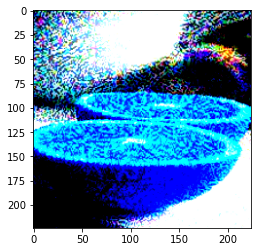

In [386]:
image = Image.open('./data/fgsmAttack/orange.JPEG').convert('RGB')

preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])
image = preprocess(image)
plt.imshow(image.permute(1, 2, 0).float())

result = torch.unsqueeze(image, 0)

In [387]:
from torchvision import datasets, models, transforms

pretrained_model = models.resnet101(pretrained=True).cuda()

pretrained_model.eval()
outputs = pretrained_model(result.cuda())
_, preds = torch.max(outputs, 1)
key = str(preds.detach().cpu().numpy()[0])
print(object_categories[key])

 'soup bowl',


### 2. PGD

- have to create adversarial dataset ourselves using PGD method: https://github.com/cleverhans-lab/cleverhans/blob/master/tutorials/torch/cifar10_tutorial.py

In [319]:
#!pip install cleverhans

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


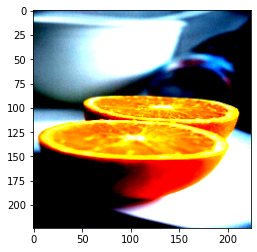

In [388]:
image = Image.open('./data/originalImagenet/n07747607_orange.JPEG').convert('RGB')

preprocess = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])
image = preprocess(image)
plt.imshow(image.permute(1, 2, 0).float())

result = torch.unsqueeze(image, 0)

In [389]:
def attack(pretrained_model, image, epsilon = 0.1):
    adv_img = projected_gradient_descent(pretrained_model, image, epsilon, 
                                                              eps_iter = 0.01, nb_iter = 40, norm = np.inf)
    # true label
    outputs1 = pretrained_model(image.cuda())
    _, preds1 = torch.max(outputs1, 1)
    key1 = str(preds1.detach().cpu().numpy()[0])
    
    # adversarial label
    outputs2 = pretrained_model(adv_img.cuda())
    _, preds2 = torch.max(outputs2, 1)
    key2 = str(preds2.detach().cpu().numpy()[0])
    
    return adv_img[0], object_categories[key1], object_categories[key2]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True Label:  'orange',
Adversarial Label:  'soup bowl',


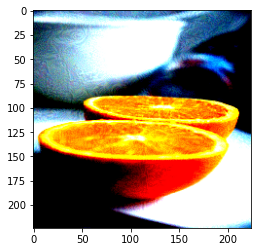

In [390]:
pretrained_model = models.resnet101(pretrained=True).cuda()
pretrained_model.eval()

adv_img, true_label, output_label = attack(pretrained_model, result.cuda())

plt.imshow(adv_img.detach().cpu().permute(1, 2, 0))

print("True Label:", true_label)
print("Adversarial Label:", output_label)

In [391]:
!mkdir ./data/pgdAttack

In [392]:
## generate 1000 adversarial examples
from torchvision.utils import save_image
import glob

path = './data/originalImagenet'
subset = glob.glob(path+'/*')
all_images = []
pretrained_model = models.resnet101(pretrained=True).cuda()
pretrained_model.eval()

preprocess = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

count = 0
for img in tqdm(subset):
    name = img.split('/')[3]
    image = Image.open(img).convert('RGB')
    image = preprocess(image)
    result = torch.unsqueeze(image, 0)
    adv_img, true_label, output_label = attack(pretrained_model, result.cuda())
    save_image(adv_img, './data/pgdAttack/'+name)
    
    if(true_label!=output_label):
        count += 1
        
print("Of 1000 images, total", count, "images had labels adversarily modified")

100%|██████████████████████████████████████████████████| 1000/1000 [30:09<00:00,  1.81s/it]

Of 1000 images, total 1000 images had labels adversarily modified


In [80]:
# ## zip file
# %cd ./data 
# !zip -r pgdAttack.zip ./pgdAttack

## Top-k Classification Metric

- Putting all together 

In [246]:
def top_k_inf(files, captions, model, text_embeddings, k=5, attack_mode=None):
    if attack_mode is None:
        source_path = "data/originalImagenet/"
    elif attack_mode == "pgd":
        source_path = "data/pgdAttack/"
    elif attack_mode == "fgsm":
        source_path = "data/attack/"
    correct = 0
    for file in files: 
        try:
            image = preprocess_inf_img(source_path + file)
            if attack_mode == "fgsm":
                label = os.path.splitext(file)[0] # remove .JPEG from the end 
                label = ' '.join(label.split('_'))  # box_turtle"  to "box turtle" \
            else:
                label = os.path.splitext(file)[0] # remove .JPEG from the end 
                label = ' '.join(label.split('_')[1:])  # i.e "01669191_box_turtle"  to "box turtle"
            matches = find_matches_caption(model, 
                 text_embeddings,
                 image_query= result.cuda(),
                 image_captions = captions,
                 n=k)
            #print(f"Label: {label}")
            #print(f"Matches: {matches}")
            for match in matches:
                if label in match: 
                    correct += 1
        except:
            print(f"Encountered error opening image {source_path + file} and skipping")
    print(f"Attack mode is {attack_mode}")
    print(f"Correct raw value: {correct}")
    print(f"Top {k} percent: {round(correct/len(files)* 100, 2)}")

In [220]:
# No attack - originalImagnet dataset 
imagenet_files = os.listdir('data/originalImagenet')
inf_df = make_adverserial_inference_df("data/originalImagenet")
model, text_embeddings = get_text_embeddings(inf_df, "best.pt", "data/originalImagenet")

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 36.63it/s]


In [221]:
top_k_inf(imagenet_files, inf_df['caption'].values, model, text_embeddings, k=5)

Encountered error opening image data/originalImagenet/.ipynb_checkpoints and skipping
Encountered error opening image data/originalImagenet/.git and skipping
Attack mode is None
Correct raw value: 5
Top 5 percent: 0.5


In [222]:
imagenet_files = os.listdir('data/pgdAttack')
inf_df = make_adverserial_inference_df("data/pgdAttack")
model, text_embeddings = get_text_embeddings(inf_df, "best.pt", "data/pgdAttack")
top_k_inf(imagenet_files, inf_df['caption'].values, model, text_embeddings, k=5, attack_mode="pgd")

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 38.02it/s]


Attack mode is pgd
Correct raw value: 5
Top 5 percent: 0.5


In [244]:
imagenet_files = os.listdir('data/attack')
inf_df = make_adverserial_inference_df("data/attack", fgsm=True)
model, text_embeddings = get_text_embeddings(inf_df, "best.pt", "data/attack")

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 37.87it/s]


In [247]:
top_k_inf(imagenet_files, inf_df['caption'].values, model, text_embeddings, k=5, attack_mode="fgsm")

Attack mode is fgsm
Correct raw value: 6
Top 5 percent: 0.6


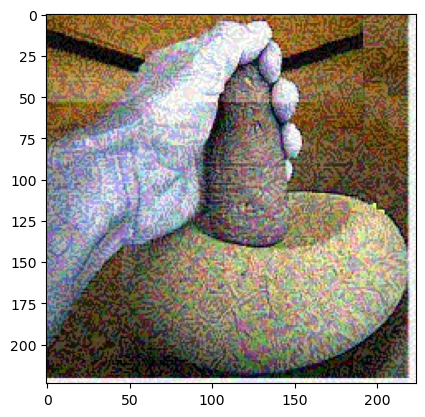

In [233]:
image = preprocess_inf_img("data/attack/mortar.JPEG")
plt.imshow(image.permute(1, 2, 0).float())

result = torch.unsqueeze(image, 0)

In [241]:
inf_df = make_adverserial_inference_df("data/attack", fgsm=True)
model, text_embeddings = get_text_embeddings(inf_df, "best.pt", "data/attack")

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 36.44it/s]


In [242]:
inf_df

,image,caption
0,Bouvier_des_Flandres.JPEG,This is Bouvier des Flandres
1,wood_rabbit.JPEG,This is wood rabbit
2,letter_opener.JPEG,This is letter opener
3,shower_curtain.JPEG,This is shower curtain
4,minivan.JPEG,This is minivan
...,...,...
992,cougar.JPEG,This is cougar
993,ant.JPEG,This is ant
994,ringneck_snake.JPEG,This is ringneck snake
995,sulphur_butterfly.JPEG,This is sulphur butterfly


In [243]:
find_matches_caption(model, 
             text_embeddings,
             image_query= result.cuda(),
             image_captions = inf_df['caption'],
             n=5)

['This is neck brace',
 'This is stethoscope',
 'This is medicine chest',
 'This is plastic bag',
 'This is hourglass']